In [35]:
import os
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import itertools
import seaborn as sns

In [3]:
data = pq.read_table("Master_labeled_ST_FINAL.parquet").to_pandas()

In [3]:
data.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,country_code,predicted_label,predicted_confidence
0,oO4r2G1M4pM,Meine besten und schlechtesten Podcasts bisher?!,2023-05-03T16:21:01Z,UCa2ikhDgZNB01WGmvI8784A,Tim Gabel,22,2023-05-04T00:00:00Z,Tim Gabel|Tim Gabel Shorts|Shorts|Tim Gabel Cl...,64096,6151,0,327,https://i.ytimg.com/vi/oO4r2G1M4pM/default.jpg,False,False,Werbung | OLAKALA CC Halfzip und Elysium Cardi...,DE,non_sport,0.995812
1,HPr2rMwWg-M,Alle Messungen falsch? Krise der Kosmologie Te...,2023-05-03T13:00:18Z,UC5E9-r42JlymhLPnDv2wHuA,Terra X Lesch & Co,28,2023-05-04T00:00:00Z,terra x lesch & co.|terra x|harald lesch|ZDF|T...,118496,4397,0,354,https://i.ytimg.com/vi/HPr2rMwWg-M/default.jpg,False,False,Das Universum expandiert beschleunigt. So weit...,DE,non_sport,0.667791
2,sQr-kcMc7zo,Till Reiners: Wer ist alles schlecht in seinem...,2023-05-03T16:00:38Z,UCCdKkuyDe0rt950_fF3lAig,ZDF Comedy,23,2023-05-04T00:00:00Z,till reiners zdf comedy|till reiners comedy|zd...,51503,1722,0,34,https://i.ytimg.com/vi/sQr-kcMc7zo/default.jpg,False,False,"Till Reiners beobachtet, dass man mit zunehmen...",DE,non_sport,0.967978
3,Cr3fcxtL6mk,Jetzt kommt alles raus! Meine Schul-Sünden wer...,2023-05-02T13:00:14Z,UC5iYuXSliCgk_mtUJa25eoQ,MATTIN Live,24,2023-05-04T00:00:00Z,survival mattin|survival mattin bunker|surviva...,254549,19810,0,902,https://i.ytimg.com/vi/Cr3fcxtL6mk/default.jpg,False,False,Jetzt kommt alles raus! Meine Schul-Sünden wer...,DE,other_sport,0.764602
4,gSRzpimk4c0,#ThoMats Dosenschießen – Thomas Müller und Mat...,2023-05-03T13:30:10Z,UCIn7wtUMkEvDCnLvT15V6aw,Thomas Müller,17,2023-05-04T00:00:00Z,Thomas Müller|Thomas Mueller|Mats Hummels|Thom...,51974,2953,0,116,https://i.ytimg.com/vi/gSRzpimk4c0/default.jpg,False,False,Der Kampf um die Meisterschaft ist im vollen G...,DE,other_sport,0.997490


In [4]:
data['predicted_label'].value_counts(normalize = True)

predicted_label
non_sport      0.680861
other_sport    0.317710
olympic        0.001429
Name: proportion, dtype: float64

In [5]:
data['country_code'].value_counts()

country_code
GB    268791
BR    268790
FR    268788
US    268787
JP    268778
CA    268742
DE    268736
MX    268598
KR    265754
IN    251277
RU    238637
Name: count, dtype: int64

In [4]:
def clean_date(df, col):
    df['date_clean'] = pd.to_datetime(df[col]).dt.tz_localize(None) #strip timezone
    df['date_clean'] = df['date_clean'].dt.normalize()   # sets time to 00:00:00

clean_date(data, 'trending_date')
data['sports'] = np.where(data['predicted_label'] == 'non_sport', 0, 1)
data['olympic'] = np.where(data['predicted_label'] == 'olympic', 1, 0)

In [5]:
data_grouped = (
    data
    .groupby(['country_code', 'date_clean'])
    .agg(
        videos=('predicted_label', 'size'),
        sports_videos=('sports', 'sum')
    )
    .reset_index()
)

data_grouped['month'] = data_grouped['date_clean'].dt.month

data_grouped["date_num"] = (data_grouped["date_clean"] - data_grouped["date_clean"].min()).dt.days

data_grouped['sports_pct'] = data_grouped['sports_videos'] / data_grouped['videos']


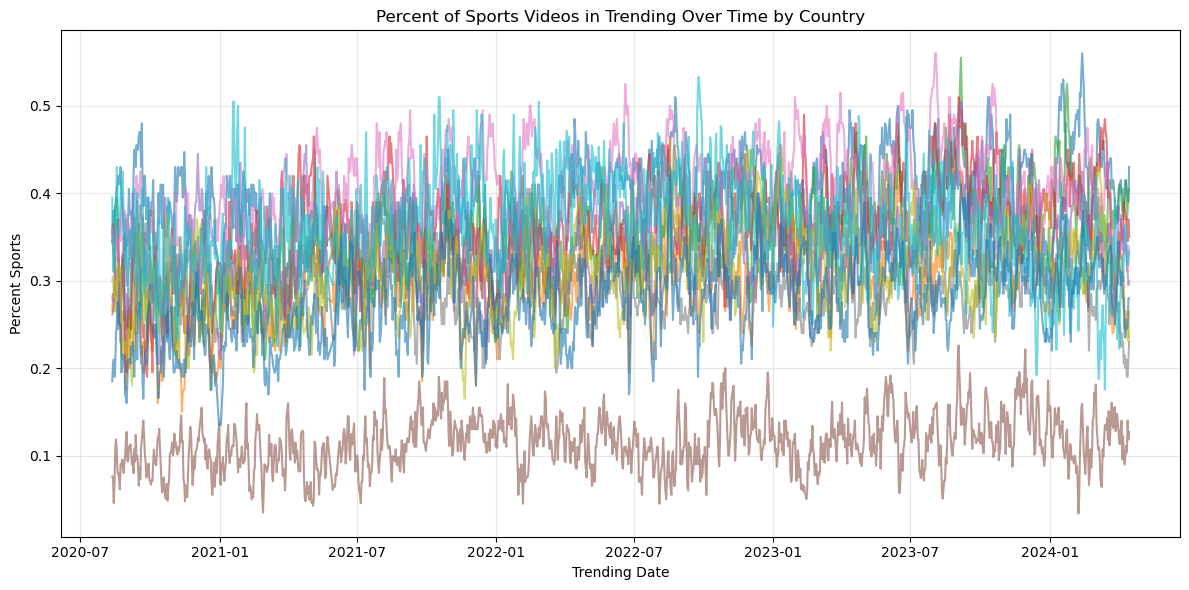

In [6]:
plt.figure(figsize=(12, 6))

# Plot one line per country
for country, group_df in data_grouped.groupby("country_code"):
    plt.plot(group_df["date_clean"], group_df["sports_pct"], alpha=0.6)

plt.title("Percent of Sports Videos in Trending Over Time by Country")
plt.xlabel("Trending Date")
plt.ylabel("Percent Sports")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
import kagglehub

# Download latest version
summer_path = kagglehub.dataset_download("piterfm/tokyo-2020-olympics")

winter_path = kagglehub.dataset_download("piterfm/beijing-2022-olympics")

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
os.listdir(summer_path)

['athletes.csv',
 'technical_officials.csv',
 'medals_total.csv',
 'coaches.csv',
 'medals.csv']

In [8]:
summer_medals = pd.read_csv(os.path.join(summer_path,'medals.csv'))

winter_medals = pd.read_csv(os.path.join(winter_path,'medals.csv'))

In [12]:
print(summer_medals['country_code'].unique())
print(data_grouped['country_code'].unique())
#need to crosswalk over from 3 letter labels to 2

['KOR' 'NED' 'MEX' 'ECU' 'BEL' 'SLO' 'HUN' 'ITA' 'CHN' 'ROU' 'EST' 'JPN'
 'TPE' 'FRA' 'KAZ' 'KOS' 'UKR' 'MGL' 'IRI' 'SRB' 'ROC' 'SUI' 'TUN' 'THA'
 'ESP' 'ISR' 'IND' 'INA' 'GER' 'AUT' 'CAN' 'USA' 'GEO' 'BRA' 'GBR' 'BUL'
 'AUS' 'UZB' 'TUR' 'COL' 'CZE' 'HKG' 'DEN' 'KUW' 'JOR' 'CRO' 'EGY' 'CIV'
 'NOR' 'NZL' 'PHI' 'RSA' 'MKD' 'CUB' 'BER' 'TKM' 'LAT' 'IRL' 'POL' 'FIJ'
 'ARG' 'VEN' 'POR' 'SVK' 'SMR' 'FIN' 'ETH' 'UGA' 'AZE' 'GRE' 'DOM' 'SWE'
 'JAM' 'MAS' 'BLR' 'QAT' 'ARM' 'MAR' 'KEN' 'PUR' 'NAM' 'NGR' 'GHA' 'KGZ'
 'SYR' 'BAH' 'GRN' 'BUR' 'LTU' 'BOT' 'BRN' 'MDA' 'KSA']
['BR' 'CA' 'DE' 'FR' 'GB' 'IN' 'JP' 'KR' 'MX' 'RU' 'US']


In [9]:
iso2_to_iso3 = {
    "DE": "DEU",
    "FR": "FRA",
    "GB": "GBR",
    "IN": "IND",
    "JP": "JPN",
    "KR": "KOR",
    "CA": "CAN",
    "BR": "BRA",
    "US": "USA",
    "MX": "MEX",
    "RU": "RUS" 
}

data_grouped['country_code_iso3'] = data_grouped['country_code'].map(iso2_to_iso3)

#Russian Olympic Committee
summer_medals['country_code_iso3'] = summer_medals['country_code'].replace({'ROC': 'RUS'})
winter_medals['country_code_iso3'] = winter_medals['country_code'].replace({'ROC': 'RUS'})

In [10]:
clean_date(summer_medals, 'medal_date')
clean_date(winter_medals, 'medal_date')

In [11]:
summer_min = summer_medals['medal_date'].min()
summer_max = summer_medals['medal_date'].max()

winter_min = winter_medals['medal_date'].min()
winter_max = winter_medals['medal_date'].max()

data_grouped['olympic_period_summer'] = (
    (data_grouped['date_clean'] >= summer_min) &
    (data_grouped['date_clean'] <= summer_max)
).astype(int)

data_grouped['olympic_period_winter'] = (
    (data_grouped['date_clean'] >= winter_min) &
    (data_grouped['date_clean'] <= winter_max)
).astype(int)

data_grouped['olympic_period'] = data_grouped['olympic_period_summer'] + data_grouped['olympic_period_winter']

Estimate medal effects seperately by country - Russia may have an especially low effect for this because their team didn't officially compete

In [12]:
medals = pd.concat([summer_medals, winter_medals], ignore_index=True)
medals['gold']   = (medals['medal_code'] == 1).astype(int)
medals['silver'] = (medals['medal_code'] == 2).astype(int)
medals['bronze'] = (medals['medal_code'] == 3).astype(int)

daily_medals = (
    medals.groupby(['date_clean', 'country_code_iso3'])
          .agg({
              'gold': 'sum',
              'silver': 'sum',
              'bronze': 'sum'
          })
          .reset_index()
)

data_grouped = data_grouped.merge(
    daily_medals,
    left_on=['date_clean', 'country_code_iso3'],
    right_on=['date_clean', 'country_code_iso3'],
    how='left'
)

data_grouped[['gold', 'silver', 'bronze']] = data_grouped[['gold', 'silver', 'bronze']].fillna(0)

In [13]:
data_grouped['medal_count'] = data_grouped['gold'] + data_grouped['silver'] + data_grouped['bronze']
data_grouped['medal_score'] = 3*data_grouped['gold'] + 2*data_grouped['silver'] + data_grouped['bronze']

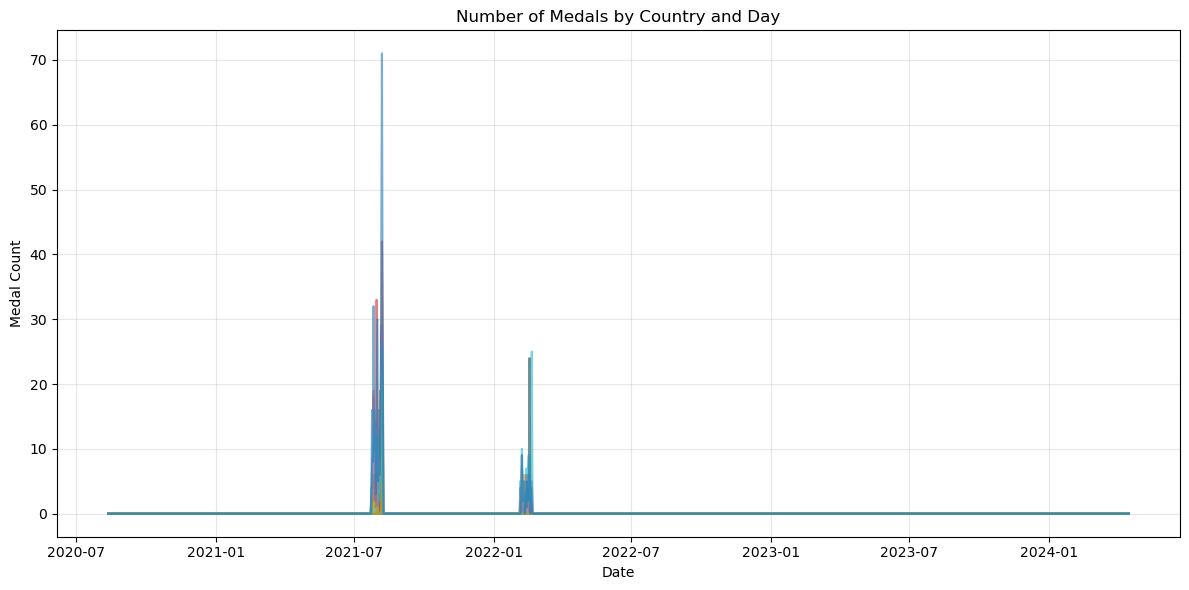

In [14]:
plt.figure(figsize=(12, 6))

for country, group_df in data_grouped.groupby("country_code_iso3"):
    plt.plot(group_df["date_clean"], group_df["medal_count"], alpha=0.6)

plt.title("Number of Medals by Country and Day")
plt.xlabel("Date")
plt.ylabel("Medal Count")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
data_grouped['sports_videos'].var(), data_grouped['sports_videos'].mean()

(395.3864570393661, 63.72423034634414)

Variance(y) >> Mean(y)
Thus, the data are overdispersed and negative binomial is more appropriate than Poisson

Base Model

In [16]:
model = smf.glm(
    formula="sports_videos ~ olympic_period + C(country_code_iso3) + date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")
print(model.summary())

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:          sports_videos   No. Observations:                14552
Model:                            GLM   Df Residuals:                    14528
Model Family:        NegativeBinomial   Df Model:                           23
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -74354.
Date:                Wed, 10 Dec 2025   Deviance:                       334.92
Time:                        17:10:11   Pearson chi2:                     321.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08295
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [17]:
data_grouped['country_code_iso3'].unique() #Brazil is the reference group

array(['BRA', 'CAN', 'DEU', 'FRA', 'GBR', 'IND', 'JPN', 'KOR', 'MEX',
       'RUS', 'USA'], dtype=object)

Is time trend different by country?

In [18]:
model = smf.glm(
    formula="sports_videos ~ olympic_period + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")
print(model.summary())

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:          sports_videos   No. Observations:                14552
Model:                            GLM   Df Residuals:                    14518
Model Family:        NegativeBinomial   Df Model:                           33
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -74343.
Date:                Wed, 10 Dec 2025   Deviance:                       314.65
Time:                        17:10:27   Pearson chi2:                     302.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08422
Covariance Type:                  HC3                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Are summer and winter olympic effects different?

In [ ]:
model = smf.glm(
    formula="sports_videos ~ olympic_period_summer + olympic_period_winter + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")
print(model.summary())
#Yes, summer effect is larger

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:          sports_videos   No. Observations:                14552
Model:                            GLM   Df Residuals:                    14517
Model Family:        NegativeBinomial   Df Model:                           34
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -74343.
Date:                Wed, 10 Dec 2025   Deviance:                       314.51
Time:                        13:16:04   Pearson chi2:                     302.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08423
Covariance Type:                  HC3                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Are Olympic Period effects different by country?

In [ ]:
model = smf.glm(
    formula="sports_videos ~ C(country_code_iso3) * olympic_period_winter + C(country_code_iso3) * olympic_period_summer + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")
print(model.summary())
#There is quite strong heterogeneity in summer/winter olympic effects between countries

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:          sports_videos   No. Observations:                14552
Model:                            GLM   Df Residuals:                    14497
Model Family:        NegativeBinomial   Df Model:                           54
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -74342.
Date:                Wed, 10 Dec 2025   Deviance:                       311.41
Time:                        13:20:57   Pearson chi2:                     299.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08443
Covariance Type:                  HC3                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

Is medal count or medal score a better predictor?

In [ ]:
model = smf.glm(
    formula="sports_videos ~ medal_count + C(country_code_iso3) * olympic_period_winter + C(country_code_iso3) * olympic_period_summer + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")

coef_medal_count = model.params["medal_count"]
se_medal_count   = model.bse["medal_count"]

model = smf.glm(
    formula="sports_videos ~ medal_score + C(country_code_iso3) * olympic_period_winter + C(country_code_iso3) * olympic_period_summer + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")

coef_medal_score = model.params["medal_score"]
se_medal_score   = model.bse["medal_score"]

print("Medal Count:", coef_medal_count, "SE:", se_medal_count)
print("Medal Score:", coef_medal_score, "SE:", se_medal_score)
#Neither are even close to significant, proceeding with medal_count because it has a positive estimate

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Medal Count: 8.301061787211513e-05 SE: 0.0006517669075733239
Medal Score: -0.0001420275840989093 SE: 0.00023233716213738422


What about lagged medal count?

In [32]:
data_grouped = data_grouped.sort_values(["country_code", "date_clean"])

for l in range(1, 8):  # 1 to 7
    data_grouped[f"medal_count_lag{l}"] = (
        data_grouped.groupby("country_code")["medal_count"].shift(l)
    )

lag_cols = [f"medal_count_lag{l}" for l in range(1, 8)]
data_grouped[lag_cols] = data_grouped[lag_cols].fillna(0)

for t in range(2, 8):
    data_grouped[f"rolling_medals_{t}"] = (
        data_grouped.groupby("country_code")["medal_count"]
        .rolling(t, min_periods=1)
        .sum()
        .reset_index(0, drop=True)
    )
#rolling sum

In [37]:
results = []

for i in range(2, 8):      # rolling windows: 2–7
    for j in range(1, 8):  # lags: 1–7
        
        # build formula dynamically
        lag_terms = " + ".join([f"medal_count_lag{k}" for k in range(1, j+1)])
        roll_term = f"rolling_medals_{i}"
        
        formula = (
            f"sports_videos ~ {roll_term} + {lag_terms} + "
            "C(country_code_iso3) * olympic_period_winter + "
            "C(country_code_iso3) * olympic_period_summer + "
            "C(country_code_iso3) * date_num + "
            "C(month)"
        )
        
        # fit model
        model = smf.glm(
            formula=formula,
            data=data_grouped,
            family=sm.families.NegativeBinomial(),
            offset=np.log(data_grouped["videos"])
        ).fit(cov_type="HC3")
        
        # store results
        results.append({
            "rolling_window": i,
            "max_lag": j,
            "-loglik": model.llf * -1,
            "AIC": model.aic,
            "BIC": model.bic
        })

# results table
grid_results = pd.DataFrame(results)
grid_results

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative b

,rolling_window,max_lag,-loglik,AIC,BIC
0,2,1,74341.814770,148797.629540,-138630.206180
1,2,2,74341.785591,148799.571182,-138620.679054
2,2,3,74341.743101,148801.486203,-138611.178549
3,2,4,74341.704537,148803.409074,-138601.670194
4,2,5,74341.660943,148805.321885,-138592.171899
5,2,6,74341.614616,148807.229232,-138582.679069
6,2,7,74341.595920,148809.191840,-138573.130977
7,3,1,74341.798888,148797.597777,-138630.237942
8,3,2,74341.785591,148799.571182,-138620.679054
9,3,3,74341.743101,148801.486203,-138611.178549


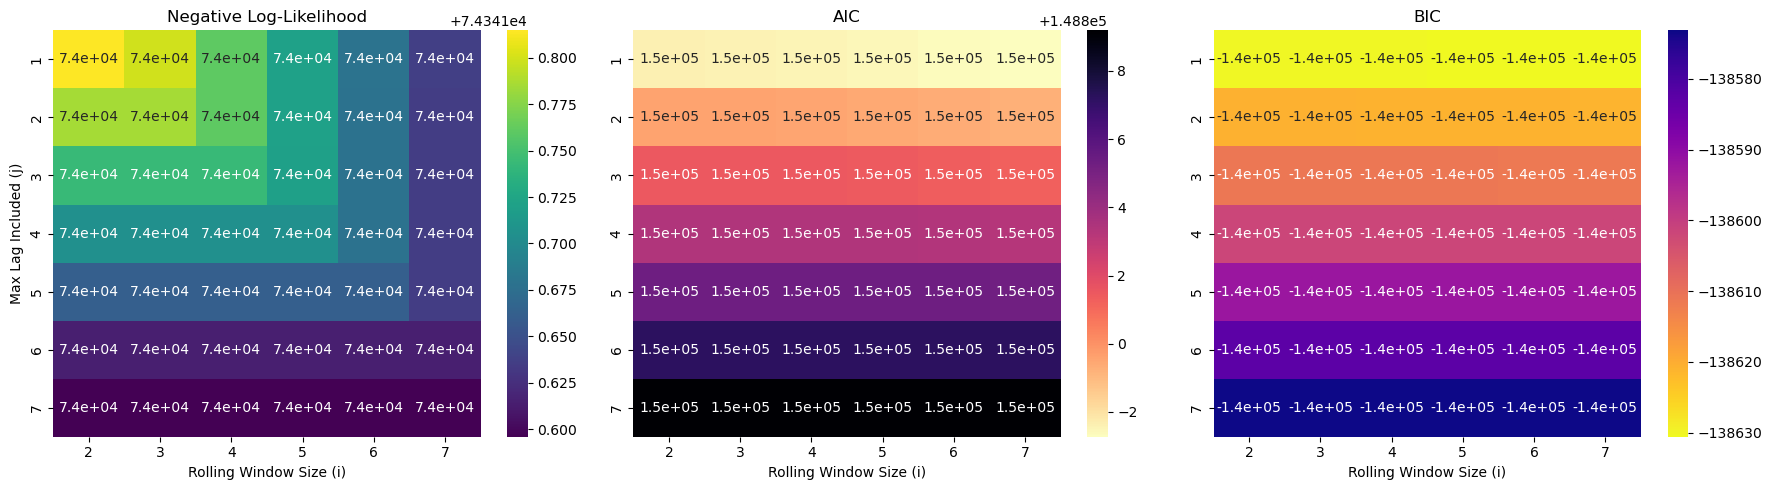

In [ ]:
pivot_ll  = grid_results.pivot(index="max_lag", columns="rolling_window", values="-loglik")
pivot_aic = grid_results.pivot(index="max_lag", columns="rolling_window", values="AIC")
pivot_bic = grid_results.pivot(index="max_lag", columns="rolling_window", values="BIC")

plt.figure(figsize=(18, 5))

# --- Log-likelihood ---
plt.subplot(1, 3, 1)
sns.heatmap(pivot_ll, annot=True, cmap="viridis")
plt.title("Negative Log-Likelihood")
plt.xlabel("Rolling Window Size")
plt.ylabel("Max Lag Included")

# --- AIC ---
plt.subplot(1, 3, 2)
sns.heatmap(pivot_aic, annot=True, cmap="magma_r")
plt.title("AIC")
plt.xlabel("Rolling Window Size")
plt.ylabel("")

# --- BIC ---
plt.subplot(1, 3, 3)
sns.heatmap(pivot_bic, annot=True, cmap="plasma_r")
plt.title("BIC")
plt.xlabel("Rolling Window Size")
plt.ylabel("")

plt.tight_layout()
plt.show()

Based on these metrics, we should only include 1-period lag